In [1]:
import numpy as np
# torch imports
import torch
# gamma function will be needed
from scipy.special import gamma as Gamma

In [2]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
# set fonttype
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42

%matplotlib inline

### Load curves
---

In [38]:
# exp params
N = 3000
n_steps = 100
lr, momentum = 1.25, 0.0
# datasets
dataset = 'sgemm_product'
# dataset = 'bike_sharing'
# dataset = 'mnist'
# exp dir
exp_root_dir = '../output'
exp_name = 'compare_4_regimes_serial'

data_dir = f'{exp_root_dir}/{exp_name}/N={N}/{dataset}/lr={lr}/momentum={momentum}'

In [39]:
exp_data    = torch.load(f'{data_dir}/data.pth')
loss_curves = torch.load(f'{data_dir}/loss_curves_4_regimes.pth')

In [41]:
batch_sizes = [key[0] for key in loss_curves.keys()]

In [42]:
batch_size = 10

In [43]:
loss_curves_nn = []
# collect curves
for i in range(exp_data['nn_runs']):
    loss_curves_nn.append(
        np.array(loss_curves[(batch_size, lr, momentum)][f'mlp/{i}'], dtype=np.float32)
    )
loss_curves_nn = np.stack(loss_curves_nn, axis=0)
# get mean and std nn loss curve
loss_curves_nn_mean = loss_curves_nn.mean(axis=0)
loss_curves_nn_std = loss_curves_nn.std(axis=0)

In [44]:
loss_curves_ln = []
# collect curves
for i in range(exp_data['linearized_runs']):
    loss_curves_ln.append(
        np.array(loss_curves[(batch_size, lr, momentum)][f'linearized/{i}'], dtype=np.float32)
    )
loss_curves_ln = np.stack(loss_curves_ln, axis=0)
# get mean and std nn loss curve
loss_curves_ln_mean = loss_curves_ln.mean(axis=0)
loss_curves_ln_std = loss_curves_ln.std(axis=0)

In [45]:
loss_curves_full = loss_curves[(batch_size, lr, momentum)][f'full']

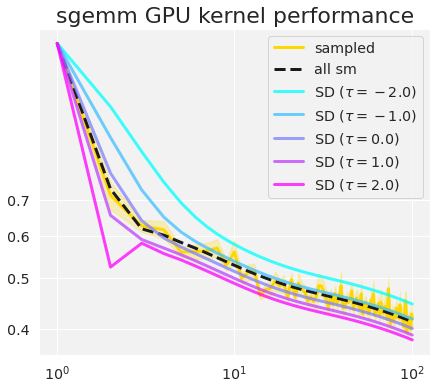

In [47]:
fig, ax = plt.subplots(figsize=(7, 6))

n_steps = len(loss_curves_nn_mean)
steps = np.arange(1, n_steps + 1)

ax.plot(steps, loss_curves_ln_mean, color='gold', label='sampled', linewidth=3);
ax.fill_between(
    steps, 
    loss_curves_ln_mean - loss_curves_ln_std / np.sqrt(exp_data['linearized_runs']),
    loss_curves_ln_mean + loss_curves_ln_std / np.sqrt(exp_data['linearized_runs']),
    color='gold', alpha=0.25
)

# full
ax.plot(steps, loss_curves_full, color='k', label='all sm', linestyle = '--', linewidth=3)

cmap = plt.get_cmap('cool', 5)
for i, tau in enumerate([-2.0, -1.0, 0.0, 1.0, 2.0]):
    ax.plot(
        steps, 
        loss_curves[(batch_size, lr, momentum)][f'sd/tau={tau:.1f}'], 
        label=rf'SD $(\tau={tau})$',
        color=cmap(i),
        linewidth=3,
        alpha=0.75
    )

ax.set_xscale('log');
ax.set_yscale('log');
# ax.set_yticks([0.3, 0.4, 0.6, 0.9, 1.3]);
# ax.set_yticks([0.4, 0.5, 0.6]);
ax.set_yticks([0.4, 0.5, 0.6, 0.7]);
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter());
ax.legend();
ax.set_title(f'sgemm GPU kernel performance', fontsize=22);
# ax.set_title(f'Bike Sharing', fontsize=22);
# ax.set_title(f'MNIST', fontsize=22);
plt.savefig(f'plots/compare_4_regimes/{dataset}.pdf')
